<a href="https://colab.research.google.com/github/malineni4u/Machine-Learning-Predictive-Alerts/blob/main/lstm_ml_sys_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:

# Simulate system health data
features = ['CPU', 'Memory', 'Load', 'TPS', 'Disk_Space']
data = []
current_time = datetime.datetime.now()
current_state = 'Healthy'
red_duration = 0

for i in range(1000):
    if current_state == 'Healthy':
        if random.random() < 0.05:
            current_state = 'Amber'
    elif current_state == 'Amber':
        if random.random() < 0.1:
            current_state = 'Red'
            red_duration = 1
        elif random.random() < 0.05:
            current_state = 'Healthy'
    elif current_state == 'Red':
        red_duration += 1
        if red_duration >= 3 and random.random() < 0.3:
            current_state = 'Healthy'
            red_duration = 0

    if current_state == 'Healthy':
        cpu = random.uniform(45, 65)
        memory = random.uniform(40, 60)
        load = random.uniform(1.0, 2.0)
        tps = random.uniform(10, 30)
        disk_space = random.uniform(20, 50)
    elif current_state == 'Amber':
        cpu = random.uniform(65, 85)
        memory = random.uniform(60, 80)
        load = random.uniform(2.5, 4.0)
        tps = random.uniform(30, 500)
        disk_space = random.uniform(10, 20)
    else:  # Red
        cpu = random.uniform(85, 100)
        memory = random.uniform(80, 100)
        load = random.uniform(4.0, 6.0)
        tps = random.uniform(1000, 2000)
        disk_space = random.uniform(1, 10)

    data.append({
        'Timestamp': current_time,
        'CPU': cpu,
        'Memory': memory,
        'Load': load,
        'TPS': tps,
        'Disk_Space': disk_space,
        'Outcome': current_state
    })

    current_time += datetime.timedelta(minutes=5)

# Create DataFrame and features
df = pd.DataFrame(data)
df['Delta_CPU'] = df['CPU'].diff().fillna(0)
df['Moving_Avg_Load'] = df['Load'].rolling(window=3).mean().fillna(method='bfill')
df['Slope_TPS'] = df['TPS'].diff().fillna(0)
df['Rolling_STD_TPS'] = df['TPS'].rolling(window=3).std().fillna(0)
df['Outcome_Label'] = df['Outcome'].map({'Healthy': 0, 'Amber': 1, 'Red': 2})

df.value_counts('Outcome')

<ipython-input-2-80f454228aa1>:58: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Moving_Avg_Load'] = df['Load'].rolling(window=3).mean().fillna(method='bfill')


,count
Outcome,
Healthy,733
Amber,207
Red,60


In [3]:
# Prepare dataset
extended_features = [
    'CPU', 'Memory', 'Load', 'TPS', 'Disk_Space',
    'Delta_CPU', 'Moving_Avg_Load', 'Slope_TPS', 'Rolling_STD_TPS'
]

X = df[extended_features]
y = df['Outcome_Label']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Create LSTM sequences
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y, time_steps=12)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

In [4]:
# Train LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
model.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weights, validation_split=0.1, verbose=0)


In [6]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8198 - loss: 0.5565
Test Loss: 0.5769
Test Accuracy: 0.8232


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


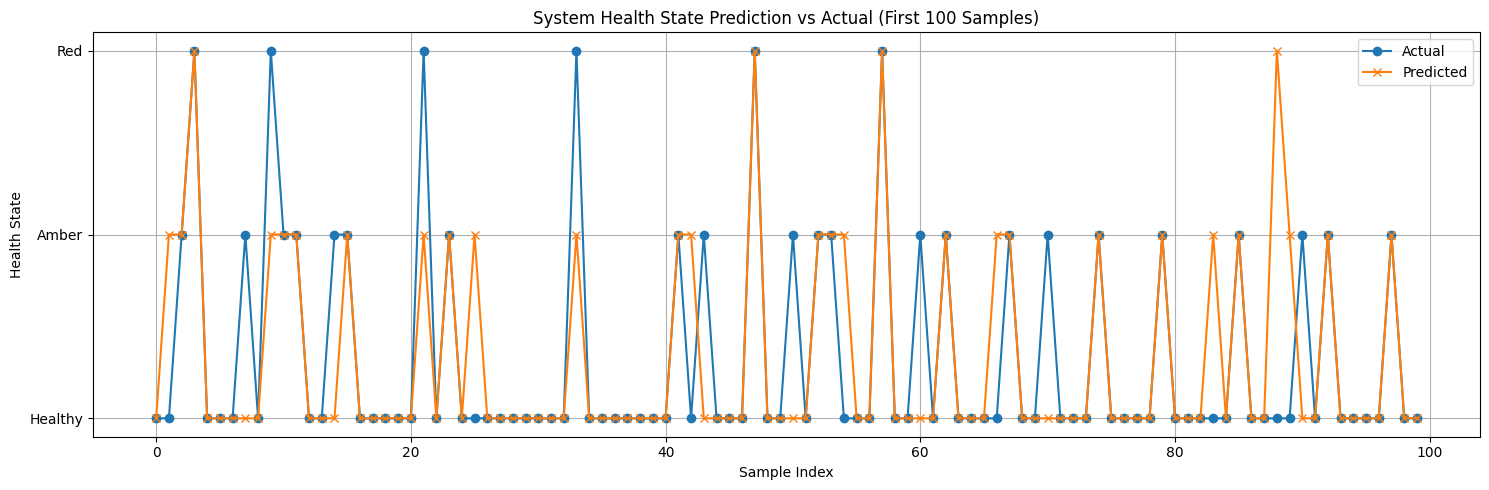

<Figure size 600x500 with 0 Axes>

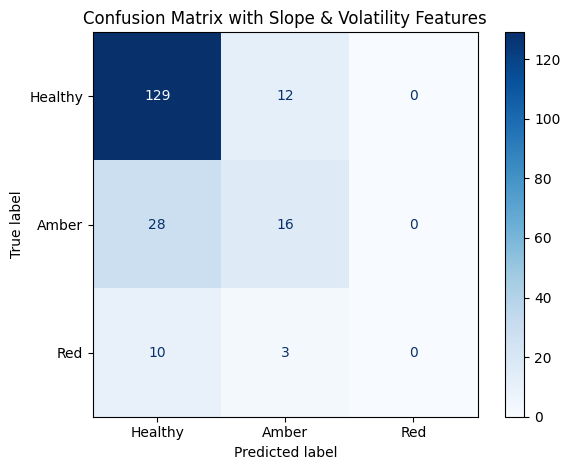

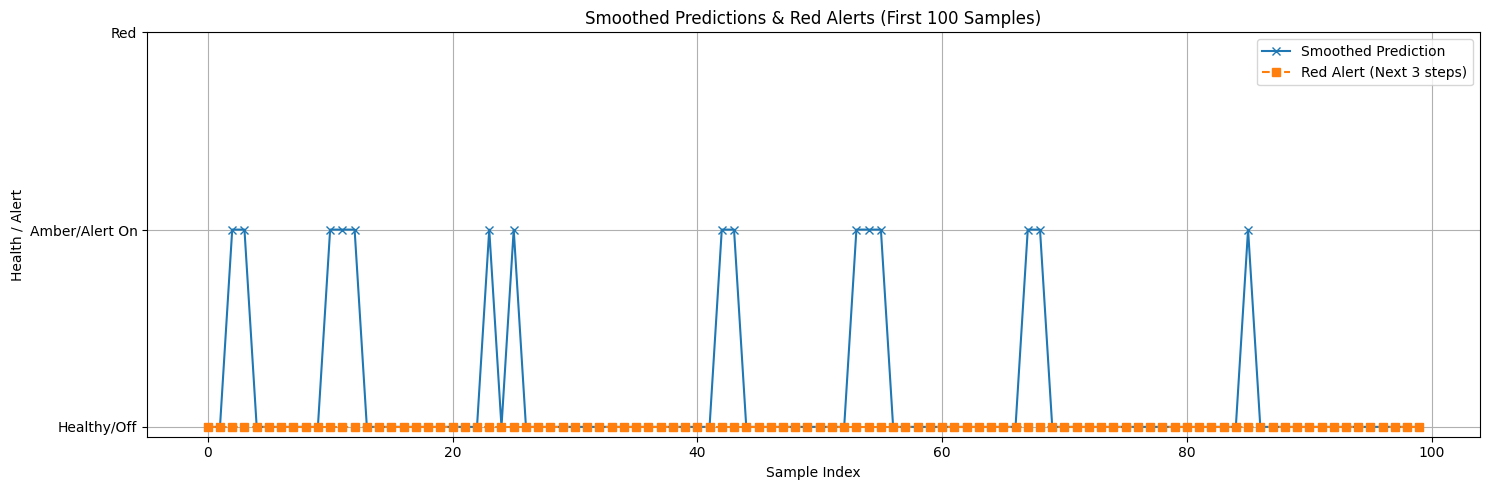

In [7]:
pred_probs = model.predict(X_test)
predicted_classes = np.argmax(pred_probs, axis=1)

# Prepare data for plot
actual_numeric = [y for y in y_test]
predicted_numeric = [p for p in predicted_classes]

plt.figure(figsize=(15, 5))
plt.plot(actual_numeric[:100], label='Actual', marker='o')
plt.plot(predicted_numeric[:100], label='Predicted', marker='x')
plt.title('System Health State Prediction vs Actual (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Health State')
plt.yticks([0, 1, 2], ['Healthy', 'Amber', 'Red'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def smooth_predictions(preds, window_size=3):
    smoothed = []
    for i in range(len(preds)):
        start = max(0, i - window_size + 1)
        window = preds[start:i + 1]
        most_common = np.bincount(window).argmax()
        smoothed.append(most_common)
    return smoothed

smoothed_preds = smooth_predictions(predicted_classes, window_size=3)

# Confusion matrix
cm = confusion_matrix(y_test, smoothed_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Amber', 'Red'])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix with Slope & Volatility Features")
plt.grid(False)
plt.tight_layout()
plt.show()

# Predict Red alerts in the next 3 steps
alert_flags = []
for i in range(len(smoothed_preds) - 3):
    window = smoothed_preds[i:i+3]
    alert = 1 if 2 in window else 0
    alert_flags.append(alert)

alert_flags += [0, 0, 0]

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(smoothed_preds[:100], label='Smoothed Prediction', marker='x')
plt.plot(alert_flags[:100], label='Red Alert (Next 3 steps)', marker='s', linestyle='--')
plt.title('Smoothed Predictions & Red Alerts (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Health / Alert')
plt.yticks([0, 1, 2], ['Healthy/Off', 'Amber/Alert On', 'Red'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
def predict_health(cpu, memory, load, tps, disk_space,
                   delta_cpu=0, moving_avg_load=None, slope_tps=0, rolling_std_tps=0):
    if moving_avg_load is None:
        moving_avg_load = load

    sample_input = {
        'CPU': cpu,
        'Memory': memory,
        'Load': load,
        'TPS': tps,
        'Disk_Space': disk_space,
        'Delta_CPU': delta_cpu,
        'Moving_Avg_Load': moving_avg_load,
        'Slope_TPS': slope_tps,
        'Rolling_STD_TPS': rolling_std_tps
    }

    input_order = [
        'CPU', 'Memory', 'Load', 'TPS', 'Disk_Space',
        'Delta_CPU', 'Moving_Avg_Load', 'Slope_TPS', 'Rolling_STD_TPS'
    ]

    input_array = np.array([[sample_input[feature] for feature in input_order]])
    input_scaled = scaler.transform(input_array)
    input_seq = np.repeat(input_scaled, 12, axis=0).reshape(1, 12, len(input_order))

    pred_prob = model.predict(input_seq)
    pred_class = np.argmax(pred_prob)

    label_map = {0: 'Healthy', 1: 'Amber', 2: 'Red'}
    return label_map[pred_class]

# Example usage:
predict_health(cpu=92, memory=87, load=5.3, tps=1550, disk_space=7)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


'Red'

In [9]:
predict_health(
    cpu=55,             # Moderate CPU
    memory=50,          # Well within limits
    load=1.8,           # Low system load
    tps=25,             # <30 TPS
    disk_space=30       # Plenty of space
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


'Healthy'

In [10]:
predict_health(
    cpu=80,
    memory=79,
    load=2.8,
    tps=450,
    disk_space=14
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


'Amber'